In [5]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import fast_sampler
from SALib.analyze import fast

In [6]:
def model_reduc(t, z, n_1, mu_T, delta, mu_N, v, n_2):

    dT = (n_1*(1 - z[0] - z[2])*(mu_T - z[0] - (z[1]/delta) - z[2])) + z[2] - (n_2*z[0]) -(v*(1 - z[1] - (delta*z[2]))*z[0])
    dN =(v*(1 - z[1] - (delta*z[2]))*(mu_N - (delta*z[0]) - z[1] - (delta*z[2]))) + (n_2*delta*z[2]) - z[1] -(n_1*(1 - z[0] - z[2])*z[1])
    dB = ((n_1/delta)*(1 - z[0] - z[2])*z[1]) + (v*(1 - z[1] - (delta*z[2]))*z[0]) - ((n_2 + 1)*z[2])
    dz = [dT, dN, dB]

    return dz

In [7]:
A0_array = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

sols = []

for A_01 in A0_array:
    A_0 = (172635*A_01*1.85e-18)/1.66e-24
    k_on_min = 5e4
    rho_T_min = 5e4/5
    k_on_max = 5e5
    k_off = 1e-4
    q_off = 4.7e-3
    n_2 = k_off/q_off
    rho_T_max = 5e5/5
    rho_N_min = 1e5/3
    rho_N_max = 5e5/3
    n_1_min = k_on_min*A_01*rho_T_min*(1/q_off)
    n_1_max = k_on_max*A_01*rho_T_max*(1/q_off)
    Tr0 = ((A_01/4e-6)**2)/(0.0095**2 + (A_01/4e-6)**2)
    mu_T_min = (A_0 + (Tr0*rho_T_max))/rho_T_max
    mu_T_max = (A_0 + (Tr0*rho_T_min))/rho_T_min
    delta_max = rho_T_max/rho_N_min
    delta_min = rho_T_min/rho_N_max
    q_on_min = 1e3
    q_on_max = 5e3
    v_min = q_on_min*A_01*rho_N_min*(1/q_off)
    v_max = q_on_max*A_01*rho_N_max*(1/q_off)
    mu_N_min = (A_0 + (Tr0*rho_N_max))/rho_N_max
    mu_N_max = (A_0 + (Tr0*rho_N_min))/rho_N_min

    problem = {
    'num_vars': 6,
    'names': ['n_1', 'mu_T', 'delta', 'mu_N', 'v', 'n_2'],
    'bounds': np.column_stack((np.array([n_1_min, mu_T_min, delta_min, mu_N_min, v_min, n_2*0.5]), np.array([n_1_max, mu_T_max, delta_max, mu_N_max, v_max, n_2*1.5])))
    }

    vals = fast_sampler.sample(problem, 600)

    Y = np.zeros([vals.shape[0], 3, 100])

    z0 = [Tr0, 0, 0]
    t= np.geomspace(0.00000001, 100, 100)
    t_span = [0.00000001, 100]

    for i in range(vals.shape[0]):
        sol = solve_ivp(model_reduc, t_span, z0, args =(vals[i][0], vals[i][1], vals[i][2], vals[i][3], vals[i][4], vals[i][5]), method ='Radau', t_eval = t)
        Y[i][0][:] = sol.y[0]
        Y[i][1][:] = sol.y[1]
        Y[i][2][:] = sol.y[2]
    
    sols.append(Y)


In [8]:
n_1_sensitivities = np.zeros(len(A0_array))
mu_T_sensitivities = np.zeros(len(A0_array))
delta_sensitivities = np.zeros(len(A0_array))
mu_N_sensitivities = np.zeros(len(A0_array))
v_sensitivities = np.zeros(len(A0_array))
n_2_sensitivities = np.zeros(len(A0_array))

for i in range(len(A0_array)):
    Y = sols[i]
    Si = fast.analyze(problem, Y[:][0][-1], print_to_console=False)
    ST = Si['ST']
    n_1_sensitivities[i] = ST[0]
    mu_T_sensitivities[i] = ST[1]
    delta_sensitivities[i] = ST[2]
    mu_N_sensitivities[i] = ST[3]
    v_sensitivities[i] = ST[4]
    n_2_sensitivities[i] = ST[5]


ValueError: 
        Error: Number of samples in model output file must be a multiple of D,
        where D is the number of parameters.
        

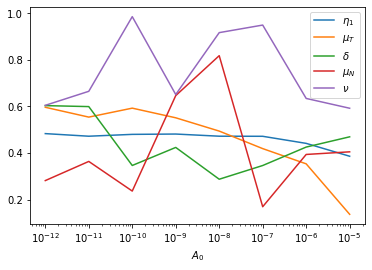

In [ ]:
plt.semilogx(A0_array, n_1_sensitivities, label=r'$\eta_1$')
plt.semilogx(A0_array, mu_T_sensitivities, label=r'$\mu_T$')
plt.semilogx(A0_array, delta_sensitivities, label=r'$\delta$')
plt.semilogx(A0_array, mu_N_sensitivities, label=r'$\mu_N$')
plt.semilogx(A0_array, v_sensitivities, label=r'$\nu$')
plt.semilogx(A0_array, n_2_sensitivities, label=r'$\eta_2$')
plt.legend(loc='best')
plt.xlabel('$A_0$')
plt.show()

In [ ]:
Si = fast.analyze(problem, Y[:][2][-1], print_to_console=False)

In [ ]:
print(Si)

{'S1': [0.2413801670900158, 0.1577734811579608, 0.29300867147614557, 0.25418212397872136, 0.3903823448183392], 'ST': [0.35970850309985014, 0.2049645990971729, 0.46920057317114483, 0.39375484794111204, 0.6453030698276542], 'S1_conf': [0.38908165451866195, 0.44856136412935177, 0.3917934166106036, 0.38125943624259406, 0.33149665572859865], 'ST_conf': [0.16879509971503945, 0.1944264735693067, 0.14623548171326134, 0.15814577159798018, 0.14874875390464995], 'names': ['n_1', 'mu_T', 'delta', 'mu_N', 'v']}
